# **CHE-1148 ASSIGNMENT-4**

## **2. Data and model drift**


**Importing relevant packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



In [ ]:
import warnings
warnings.filterwarnings("ignore")

**Importing monthly features**

In [ ]:
mth_rolling_features = pd.read_excel("/content/mth rolling features latest.xlsx")
mth_day_cnt = pd.read_excel("/content/mth_day_counts.xlsx")
retail_data = pd.read_csv("/content/Retail_Data_Response-1.csv")
days_since_last_txn = pd.read_excel("/content/days_since_last_txn.xlsx")

In [ ]:
#dropping the unnecesary column that was formed by reindexing in previous assignment
mth_rolling_features.drop('Unnamed: 0',axis=1,inplace=True)
mth_day_cnt.drop('Unnamed: 0',axis=1,inplace=True)
days_since_last_txn.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
#Creating monthly table 
temp_table_2 = pd.merge(mth_rolling_features,mth_day_cnt, on = ["CLNT_NO","ME_DT"]) #joining monthly_rolling_features and monthly_day-coint tables first
temp_table_3=pd.merge(temp_table_2,days_since_last_txn, on = ["CLNT_NO","ME_DT"]) #joining days_since_last_transcation table
monthly_table = pd.merge(temp_table_3,retail_data, left_on="CLNT_NO",right_on="customer_id") #joining retail response table
monthly_table #final required table for monthly data

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,last_monthly_purchase,days_since_last_txn,customer_id,response
0,CS1112,2011-05-31,72,1,0,0.000000,0,0,0.0,0,...,0,0,0,0,0,0,0,0,CS1112,0
1,CS1112,2011-06-30,56,1,0,0.000000,0,0,0.0,0,...,0,0,0,0,0,1,2011-06-15 00:00:00,15,CS1112,0
2,CS1112,2011-07-31,72,1,200,66.666667,72,3,1.0,1,...,0,0,0,0,0,0,2011-06-15 00:00:00,46,CS1112,0
3,CS1112,2011-08-31,96,1,224,74.666667,96,3,1.0,1,...,0,0,0,0,0,0,2011-08-19 00:00:00,12,CS1112,0
4,CS1112,2011-09-30,72,1,240,80.000000,96,3,1.0,1,...,0,0,0,0,0,0,2011-08-19 00:00:00,42,CS1112,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,2014-11-30,72,1,216,72.000000,72,3,1.0,1,...,0,0,0,0,0,0,2014-08-24 00:00:00,98,CS9000,0
323544,CS9000,2014-12-31,72,1,216,72.000000,72,3,1.0,1,...,0,0,0,0,0,0,2014-08-24 00:00:00,129,CS9000,0
323545,CS9000,2015-01-31,72,1,216,72.000000,72,3,1.0,1,...,0,0,0,0,0,0,2014-08-24 00:00:00,160,CS9000,0
323546,CS9000,2015-02-28,34,1,178,59.333333,72,3,1.0,1,...,0,1,0,0,0,0,2015-02-28 00:00:00,0,CS9000,0


**Preparing train and test set**

As per the given instructions, the training set should include  all the data prior to Dec-2013 (inclusively) and the test data is all data after Jan-2014 (inclusively). We split the main dataframe according to this conditions.

In [ ]:
#dropping CLNT_NO and customer_id column as it's not required to train our model
monthly_table.drop(["CLNT_NO","last_monthly_purchase","customer_id"], axis=1, inplace=True)

In [ ]:
#sorting dataframe based on date
monthly_table.sort_values(by="ME_DT",inplace=True)

#resetting the index
monthly_table.reset_index(drop=True, inplace=True)

In [ ]:
#train set 
train_set = monthly_table.loc[monthly_table["ME_DT"] <= '2013-12-31']
test_set = monthly_table.loc[monthly_table["ME_DT"] >= '2014-1-1']

In [ ]:
#resetting the test_set index
test_set.reset_index(drop=True, inplace=True)
test_set

,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,amt_sum_6M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,2014-01-31,72,1,348,116.000000,204,4,1.333333,2,579,...,2,0,0,0,0,0,0,0,35,0
1,2014-01-31,76,1,210,70.000000,76,3,1.000000,1,516,...,2,0,0,1,0,0,0,0,13,0
2,2014-01-31,72,1,183,61.000000,72,3,1.000000,1,353,...,1,0,0,0,0,0,0,0,88,0
3,2014-01-31,72,1,216,72.000000,72,3,1.000000,1,437,...,1,0,0,0,0,0,0,0,178,0
4,2014-01-31,72,1,210,70.000000,72,4,1.333333,2,374,...,2,0,0,0,0,0,0,0,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103255,2015-03-31,72,1,216,72.000000,72,3,1.000000,1,447,...,1,0,0,0,0,0,0,0,95,0
103256,2015-03-31,72,1,270,90.000000,122,4,1.333333,2,509,...,3,0,0,0,0,0,0,0,58,0
103257,2015-03-31,72,1,216,72.000000,72,3,1.000000,1,432,...,2,0,0,0,0,0,0,0,207,0
103258,2015-03-31,72,1,232,77.333333,88,3,1.000000,1,448,...,1,0,0,0,0,0,0,0,34,0


In [ ]:
#saving indices of unique months for using it later during plotting the dashboard
train_unique_dates = train_set["ME_DT"].unique()
test_unique_dates = test_set["ME_DT"].unique()
train_indices = []
test_indices = []

#train
for i in range(len(train_unique_dates)):
  train_indices.append(train_set[train_set["ME_DT"]== train_unique_dates[i]].index.values)
print(train_indices)

#test
for i in range(len(test_unique_dates)):
  test_indices.append(test_set[test_set["ME_DT"]== test_unique_dates[i]].index.values)
print(test_indices)


[array([   0,    1,    2, ..., 6881, 6882, 6883]), array([ 6884,  6885,  6886, ..., 13765, 13766, 13767]), array([13768, 13769, 13770, ..., 20649, 20650, 20651]), array([20652, 20653, 20654, ..., 27533, 27534, 27535]), array([27536, 27537, 27538, ..., 34417, 34418, 34419]), array([34420, 34421, 34422, ..., 41301, 41302, 41303]), array([41304, 41305, 41306, ..., 48185, 48186, 48187]), array([48188, 48189, 48190, ..., 55069, 55070, 55071]), array([55072, 55073, 55074, ..., 61953, 61954, 61955]), array([61956, 61957, 61958, ..., 68837, 68838, 68839]), array([68840, 68841, 68842, ..., 75721, 75722, 75723]), array([75724, 75725, 75726, ..., 82605, 82606, 82607]), array([82608, 82609, 82610, ..., 89489, 89490, 89491]), array([89492, 89493, 89494, ..., 96373, 96374, 96375]), array([ 96376,  96377,  96378, ..., 103257, 103258, 103259]), array([103260, 103261, 103262, ..., 110141, 110142, 110143]), array([110144, 110145, 110146, ..., 117025, 117026, 117027]), array([117028, 117029, 117030, ...,

In [ ]:
#X and y sets
X_train = train_set.drop(['response'], axis = 1)
y_train = train_set['response']
X_test = test_set.drop(['response'], axis = 1)
y_test = test_set['response']

In [ ]:
X_train.drop(['ME_DT'],axis=1, inplace=True)

In [ ]:
X_test.drop(['ME_DT'],axis=1, inplace=True)

Since it's a tree based model, we are not going to standardize the features.

**Training a Random Forest model**

I take the best optimized random forest model from previous assignments for monthly features which had a n_estimator =200, max_features="sqrt", max_depth of 15, min_samples_split =20 and ccp_alpha = 0.001. Furthermore we have already established in the previous assignments that the data is not balanced. So I set a class weight of "balanced" to my model.

In [ ]:
# Training model on standardized train set
estimator = RandomForestClassifier(random_state=42, n_estimators=200, min_samples_split = 20, max_depth = 15, ccp_alpha= 0.001,class_weight="balanced")
model_rf = estimator.fit(X_train, y_train)

In [ ]:
#Accuracy 
y_pred = model_rf.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred, normalize = True)
print("Accuracy of model on test data is:", accuracy)

Accuracy of model on test data is: 41.56013945380593


**Identifying 5 top features based on importances**

In [ ]:
#importances
importances_rf = model_rf.feature_importances_

#sorting feature importance indices
indices_rf = np.argsort(importances_rf)[::-1]

# Rearrange feature names so they match the sorted feature importances
feature_names = [X_train.columns[i] for i in indices_rf]

#top 5 features
top_5_features = feature_names[0:5]

In [ ]:
top_5_features #displaying top 5 features

['amt_max_12M', 'amt_mean_12M', 'amt_sum_12M', 'amt_max_6M', 'amt_mean_6M']



- **Baseline Scores: calculating scores on train data for the model** 

In [ ]:
#baseline scores
baseline_scores = model_rf.predict_proba(X_train)[:,1] 

# We divide by the .max() value to ensure that the upper limit is 1 since it's supposed to be a probability score.
baseline_scores = baseline_scores/baseline_scores.max() 

Text(0.5, 1.0, 'Baseline Score Distribution')

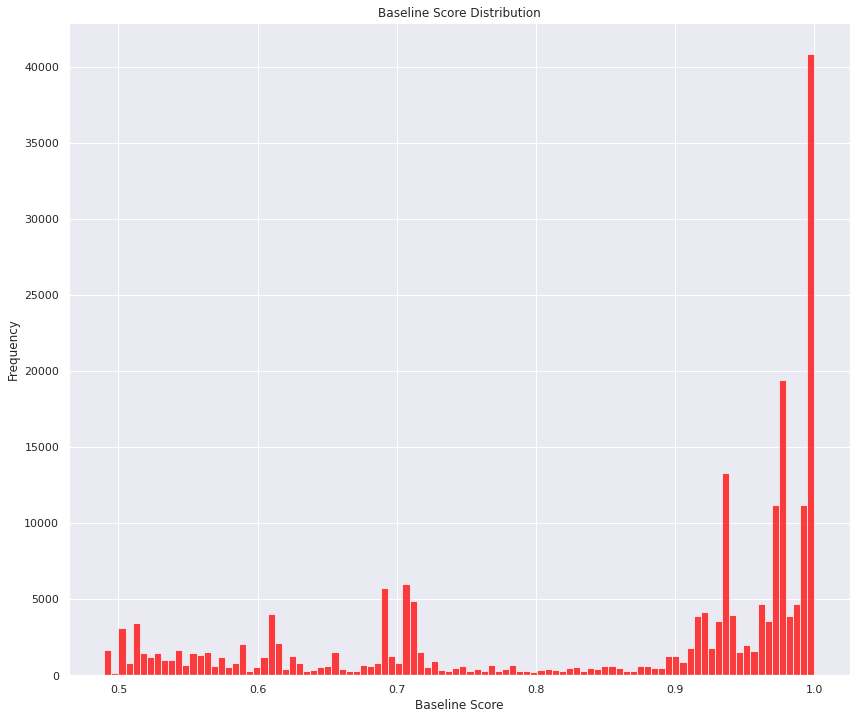

In [ ]:
#plot for baseline score distribution 
sns.set(rc={"figure.figsize":(14, 12)})
ax = sns.histplot(baseline_scores,                
                  color='red',
                  bins=100)
ax.set(xlabel='Baseline Score', ylabel='Frequency')
ax.set_title("Baseline Score Distribution")

So we note that the above is our baseline score distribution.

**- Production Scores: calulating scores of test data on model**

In [ ]:
#production scores
production_scores = model_rf.predict_proba(X_test)[:,1] 

# We divide by the .max() value to ensure that the upper limit is 1 since it's supposed to be a probability score.
production_scores = production_scores/production_scores.max() 

Text(0.5, 1.0, 'Production Score Distribution')

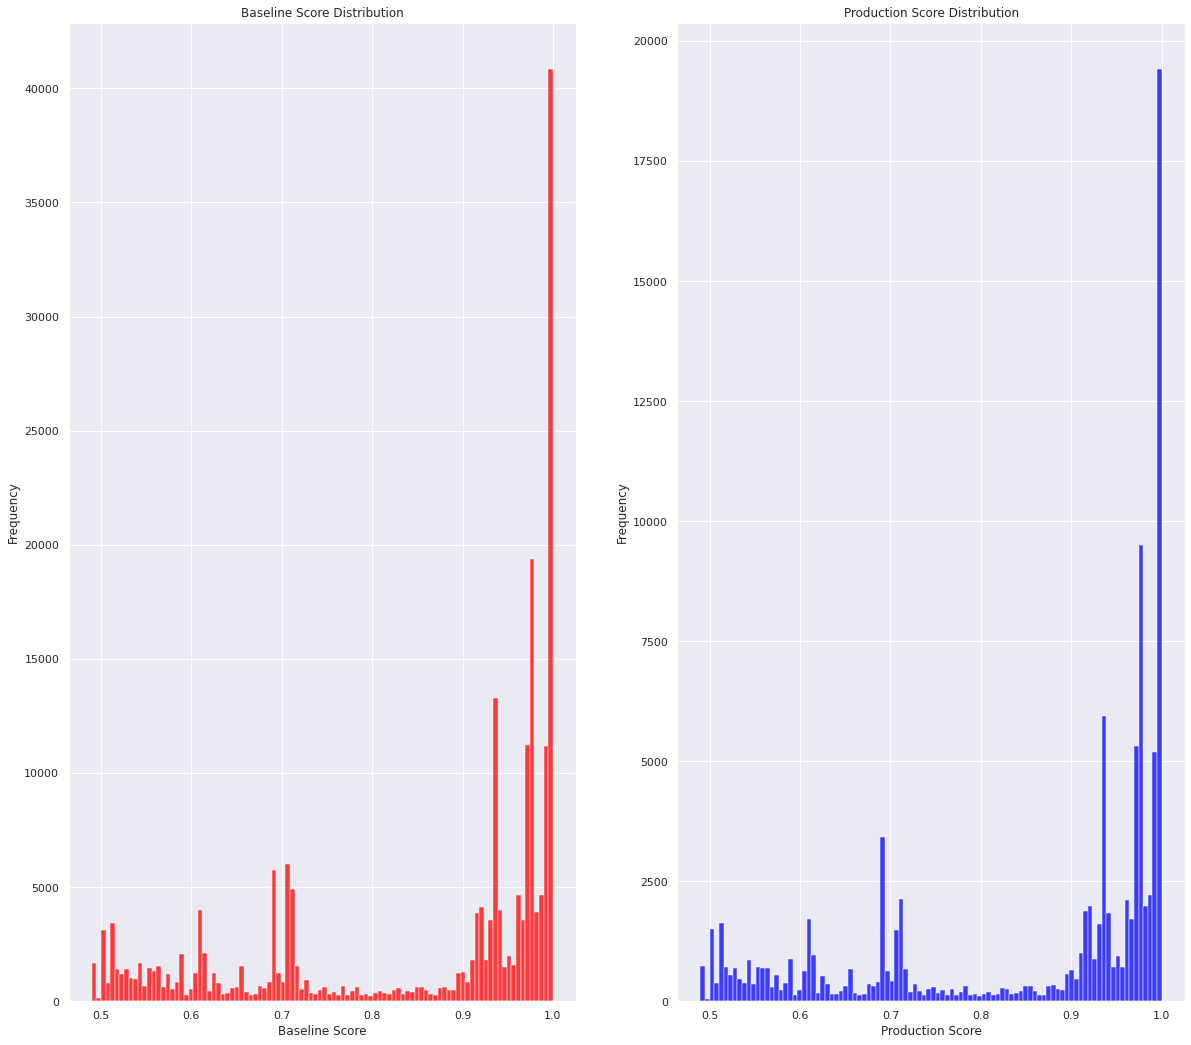

In [ ]:
#plot for production score distribution 
plt.rcParams["figure.figsize"] = [20, 18]
f, ax = plt.subplots(1, 2)
sns.histplot(baseline_scores,                
                  color='red',
                  bins=100, ax = ax[0])

sns.histplot(production_scores,                
                  color='blue',
                  bins=100, ax= ax[1])

ax[0].set(xlabel='Baseline Score', ylabel='Frequency')
ax[0].set_title("Baseline Score Distribution")
ax[1].set(xlabel='Production Score', ylabel='Frequency')
ax[1].set_title("Production Score Distribution")

By comparing distribution of both, there are drastic drift in the score frequency order in y-axis even though the nature of the distribution is similar. Furthermore, we observe that the distribution nature also changes from the scores between 0.6 to 0.8.

**Part-a: Jensen-Shannon divergence metric for monthly scores**

In [ ]:
#Creating new test set : storing the production scores corresponsing to each unique date
test_set_ms = test_set[:]
test_set_ms["target scores"] = production_scores


- Calculating left probability vector p

In [ ]:
#Ensuring every bin has approximately 10% of the population 
bin_edges = np.quantile(baseline_scores, np.arange(0, 1.1, 0.1))
bin_edges[0]=0 # We replace the first element with zero since it's the lower cap
p = np.histogram(baseline_scores, bin_edges)
p



(array([21980, 22076, 22031, 22028, 21793, 22263, 16227, 25659, 18097,
        28134]),
 array([0.        , 0.56658214, 0.68762709, 0.73022996, 0.9175505 ,
        0.93863296, 0.97230503, 0.97863824, 0.99369814, 0.99784915,
        1.        ]))

- Calculating right probabilty vector q and JS divergence

In [ ]:
#monthly js divergence score for monthly scores
js_monthlyscores = []
target_scores = []
for i in test_unique_dates:
  target_scores.append(test_set_ms[test_set_ms.ME_DT==i]['target scores'].values)
  q_ms = np.histogram(target_scores, bin_edges)
  js_monthlyscores.append(distance.jensenshannon(p[0],q_ms[0],2.0))


**Part-b: Jensen-Shannon divergence metric for the monthly top 5 features of the model**

In [ ]:
#defining function to calculate JS divergence for each feature

def drift(feature):

  #baseline
  baseline_score_top5 = X_train[feature].values
  baseline_score_top5 = baseline_score_top5/baseline_score_top5.max()

  bin_edge_new = np.linspace(min(baseline_score_top5), max(baseline_score_top5), 20)
  bin_edge_2 = np.r_[-np.inf, bin_edge_new , np.inf]
  p_2 = np.histogram( baseline_score_top5, bin_edge_2)

  #drift calculations
  js_scores = []
  for i in test_unique_dates:
    #production/target
    target_score_top5 = test_set[test_set['ME_DT']== i][feature].values
    target_score_top5 = target_score_top5/target_score_top5.max()
    q_2 = np.histogram(target_score_top5, bin_edge_2)
    js_scores.append(distance.jensenshannon(p_2[0], q_2[0], 2.0))

  return js_scores



In [ ]:
js_topfive_scores=[]
for features in top_5_features:
  js_topfive_scores.append(drift(features))

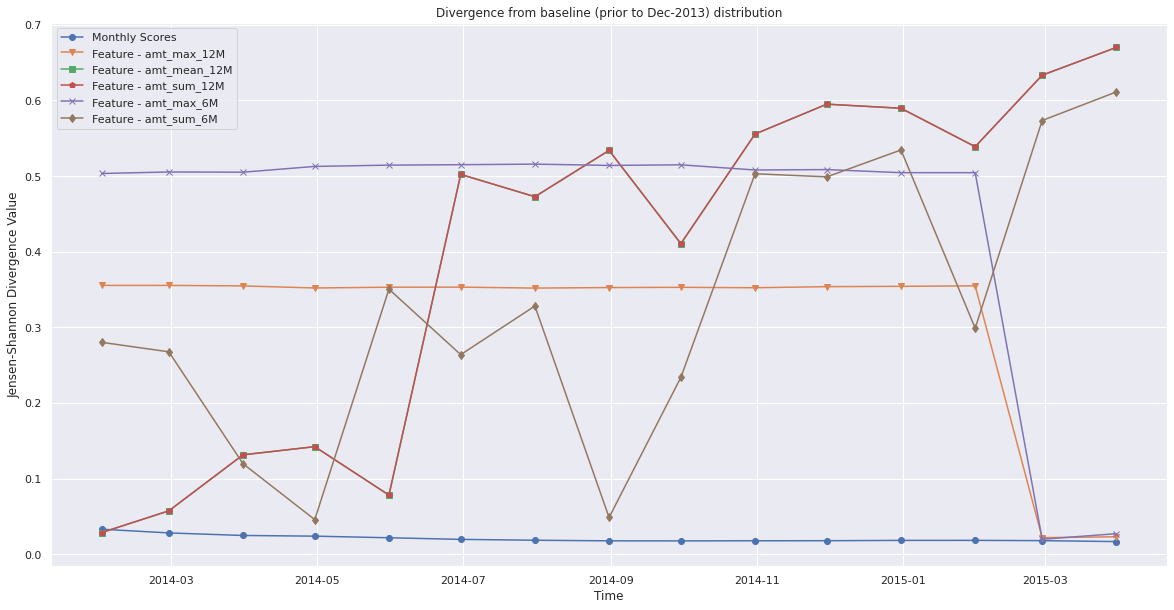

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(test_unique_dates, js_monthlyscores, '-o', label = 'Monthly Scores')
plt.plot(test_unique_dates, js_topfive_scores[0], '-v', label = 'Feature - amt_max_12M')
plt.plot(test_unique_dates, js_topfive_scores[1], '-s', label = 'Feature - amt_mean_12M')
plt.plot(test_unique_dates, js_topfive_scores[2], '-p', label = 'Feature - amt_sum_12M')
plt.plot(test_unique_dates, js_topfive_scores[3], '-x', label = 'Feature - amt_max_6M')
plt.plot(test_unique_dates, js_topfive_scores[4], '-d', label = 'Feature - amt_sum_6M')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Jensen-Shannon Divergence Value')
plt.title('Divergence from baseline (prior to Dec-2013) distribution')
plt.show()

By comparing the Jensen-Shannon divergence metric we are capturing the difference in the distribution of each of these variables from our baseline distribution.


From the above plot we see there's a drift for the overall monthly scores. When we futher dissect the rootcause and check for the top 5 features that are important predictors of our model, we see significantly large drifts from baseline. 

Let's discuss each of the top 5 features behaviour in detail.

we see for all the top 5 features the drift is greater than 0.2 for almost through out the production years.

We see that the features "amt_max_12M" and "amt_max_6M" show the maximum divergence from baseline of about 0.35 to 0.5. Hence these two features have the highest contribution to the change. However, they reached to 0 on March 2015 and discontinued from changing.

For features "amt_sum_12M" and "amt_mean_12M", the plots overlapped indicating they have a completely same drift from the baseline distribution over time which increased over time till almost 0.7.

For feature "amt_sum_6M", it is noteworthy here that the drift almost reached to 0 during May 2014 and September 2014. But it was not consistent and continued to contribute to the changes in the rest of the production years by increasing the drift beyond 0.6.

The contribution from all these 5 features affected the overall monthly scores of the model which is captured in the plot. But since the drift is below 0.2, we can consider it to be safe.

